In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from collections import Counter
sns.set()

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arbru\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('../data/final/final_df.csv')

In [6]:
df['label'] = df['label'].map({1:"HATE", 0:"NON_HATE"})


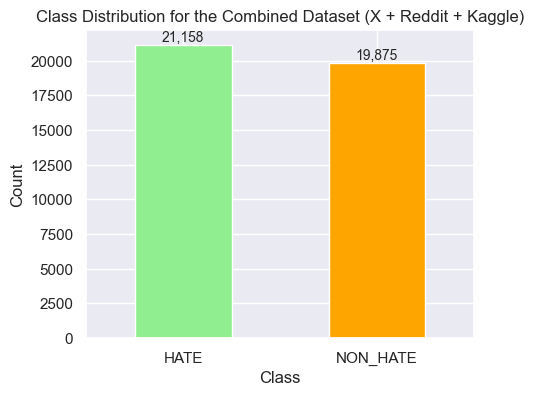

In [8]:
class_count = df['label'].value_counts()
plt.figure(figsize=(5,4))
bars = class_count.plot(kind='bar', color=['lightgreen','orange'])

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f"{bar.get_height():,}",
             ha="center", va="bottom", fontsize=10)
    
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution for the Combined Dataset (X + Reddit + Kaggle)")
plt.xticks(rotation=0)
plt.show()

In [9]:
df['label'] = df['label'].map({"HATE":1, "NON_HATE":0})

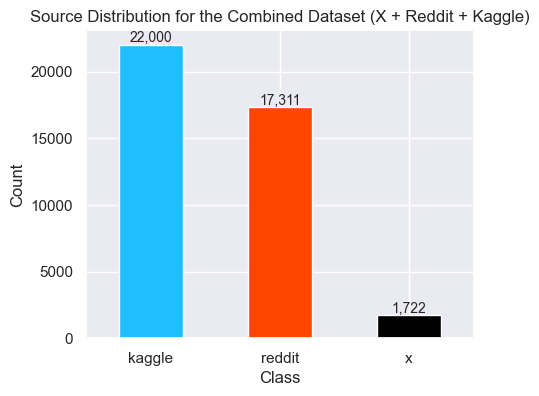

In [11]:
class_count = df['source'].value_counts()
plt.figure(figsize=(5,4))
bars = class_count.plot(kind='bar', color=['#20beff','#FF4500','black'])

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f"{bar.get_height():,}",
             ha="center", va="bottom", fontsize=10)
    
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Source Distribution for the Combined Dataset (X + Reddit + Kaggle)")
plt.xticks(rotation=0)
plt.show()

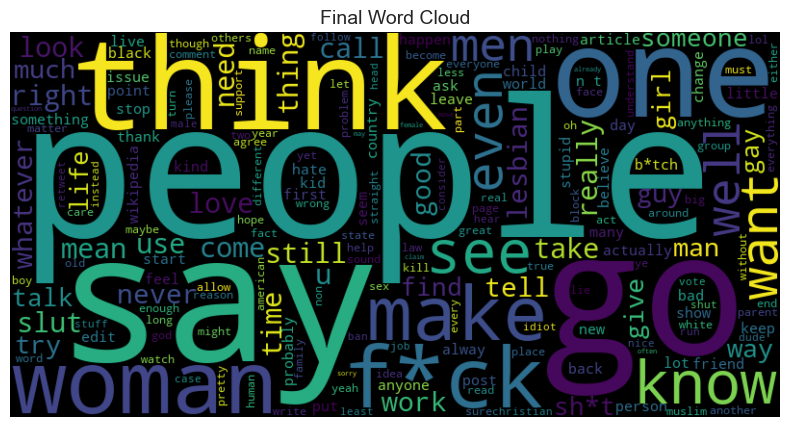

In [13]:
def censor_words(text, banned_words):
    def censor_match(match):
        word = match.group(0)
        censored_word = re.sub(r'([aeiouAEIOU])', '*', word, count=1)
        return censored_word

    pattern = r"\b(" + "|".join(re.escape(word) for word in banned_words) + r")\b"
    return re.sub(pattern, censor_match, text, flags=re.IGNORECASE)


text_data = " ".join(df["processed_text"].astype(str))
banned_words = {"fuck", "fucking", "shit", "bitch", "faggot", "nigga"}

censored_text = censor_words(text_data, banned_words)

wordcloud = WordCloud(
    width=800, height=400,
    background_color="black",
    colormap="viridis",
    max_words=200,  
    regexp=r"\b[a-zA-Z*]+\b" 
).generate(censored_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Final Word Cloud", fontsize=14)
plt.show()

In [14]:
df.drop_duplicates(inplace=True)
print(len(df))


40952


In [15]:
_df = df.copy()

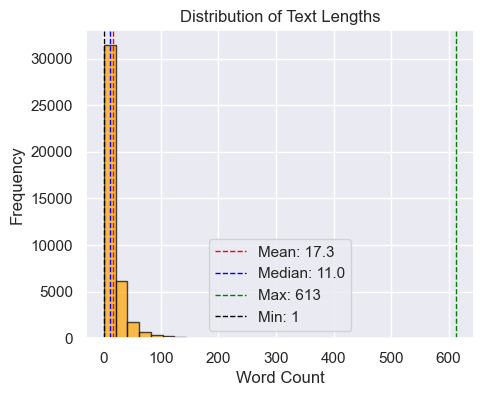

In [16]:

_df['text_length'] = _df['processed_text'].astype(str).apply(lambda x: len(x.split()))

mean_length = _df['text_length'].mean()
median_length = _df['text_length'].median()
max_length = _df['text_length'].max()
min_length = _df['text_length'].min()

plt.figure(figsize=(5, 4))
_df['text_length'].hist(bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_length}')
plt.axvline(max_length, color='green', linestyle='dashed', linewidth=1, label=f'Max: {max_length}')
plt.axvline(min_length, color='black', linestyle='dashed', linewidth=1, label=f'Min: {min_length}')

plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.legend()
plt.show()

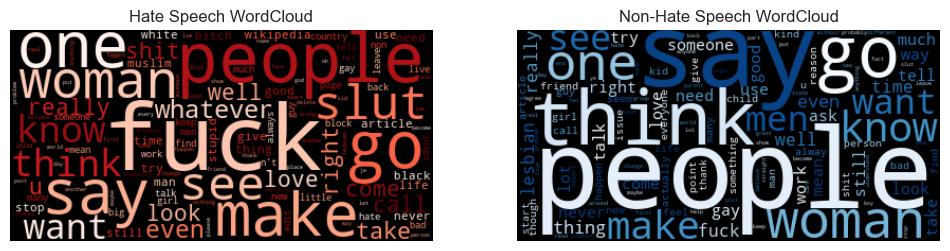

In [17]:
hate_speech = " ".join(_df[_df['label'] == 1]['processed_text'].astype(str))
non_hate_speech = " ".join(_df[_df['label'] == 0]['processed_text'].astype(str))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
wc = WordCloud(background_color="black", colormap="Reds", max_words=200).generate(hate_speech)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech WordCloud")

plt.subplot(1, 2, 2)
wc = WordCloud(background_color="black", colormap="Blues", max_words=200).generate(non_hate_speech)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Hate Speech WordCloud")

plt.show()


In [18]:

all_words = " ".join(_df['processed_text'].astype(str)).split()
word_counts = Counter(all_words)
print(word_counts.most_common(5))


[('not', 21760), ('people', 6976), ('like', 6947), ('get', 5988), ('fuck', 4930)]


In [19]:
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(_df['processed_text'].astype('str'))

sum_words = np.array(X.sum(axis=0)).flatten()


words_freq = [(word, sum_words[idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

print(words_freq[:6])  


[('look like', 422), ('information technology', 300), ('talk page', 289), ('feel like', 271), ('year old', 269), ('people like', 255)]


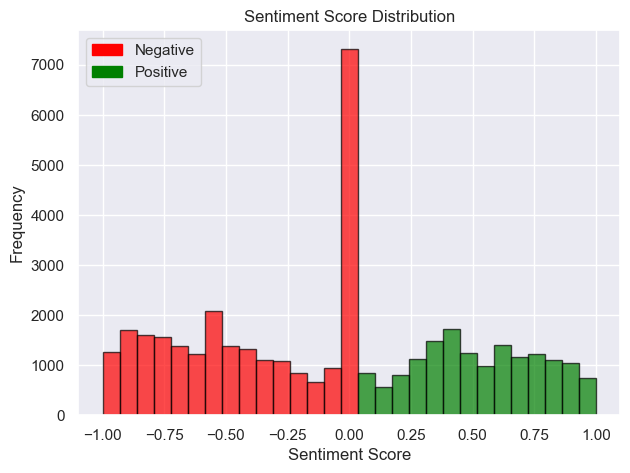

In [20]:
sia = SentimentIntensityAnalyzer()

_df['sentiment'] = _df['processed_text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
bins = np.linspace(_df['sentiment'].min(), _df['sentiment'].max(), 30)
colors = ['red' if x < 0 else 'green' for x in bins]

plt.figure(figsize=(7, 5))
n, bins, patches = plt.hist(_df['sentiment'], bins=bins, alpha=0.7, edgecolor='black')

for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

red_patch = mpatches.Patch(color='red', label='Negative')
green_patch = mpatches.Patch(color='green', label='Positive')
plt.legend(handles=[red_patch, green_patch], loc='upper left')

plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Score Distribution")

plt.show()
